# TF4ces Search Engine
## Evaluation Pipeline

Setup system paths

In [1]:
from pathlib import Path
import sys

__WORKSPACE__ = Path.cwd().parent.parent
sys.path.append(str(__WORKSPACE__))

__WORKSPACE__

PosixPath('/Users/ataago/Documents/git/TF4ces/TF4ces-search-engine')

In [2]:
# Native imports
from copy import deepcopy
from IPython.core.display import HTML

# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt

# User imports
from config.conf import __ALL_MODELS__
from src.TF4ces_search_engine.data.data_gathering import DataGathering
from src.main_ensemble import TF4cesSearchEnsemble
from src.utils.ensemble_strategy import EnsembleStrategy
from src.utils.evalutor import calc_mean_recall_n_precision

### Configs

In [3]:
# Model Names
TFIDF_MODEL = __ALL_MODELS__[0]
BM25_MODEL = __ALL_MODELS__[1]
MPNET_MODEL = __ALL_MODELS__[2]
ROBERTA_MODEL = __ALL_MODELS__[3]

# Dataset Configs
DATASET_NAME = 'lotte'
DATASET_CATEGORY = 'lifestyle'
SPLIT = 'test'

# Path Configs
TFIDF_MODEL_PATH = __WORKSPACE__ / "models/tfidf/lotte/lifestyle/tfidf.v0.0.1.pkl"
MPNET_EMB_PATH = __WORKSPACE__ / "dataset/embeddings_test/test_v0.0.1/all-mpnet-base-v2/lotte/lifestyle"
ROBERTA_EMB_PATH = __WORKSPACE__ / "dataset/embeddings_test/test_v0.0.1/all-roberta-large-v1/lotte/lifestyle"

In [4]:
FILTER_TOP_N = 3_000
VOTING_TOP_N = 100

FILTER_MODEL = {
    #TFIDF_MODEL: {'model_path': TFIDF_MODEL_PATH},
    BM25_MODEL: {'model_path': None},
}
VOTER_MODELS = {
    MPNET_MODEL: {'emb_path': MPNET_EMB_PATH},
    ROBERTA_MODEL: {'emb_path': ROBERTA_EMB_PATH},
}

#### Path checks

In [5]:
drive_link = "https://drive.google.com/file/d/1x-lOZMwBK5Ea9eCDE18gQCTnukZ16xQT/view?usp=share_link"

if not MPNET_EMB_PATH.exists() or not ROBERTA_EMB_PATH.exists():
    raise Exception(f"Embeddings for MPNET model is missing at this path: '{MPNET_EMB_PATH}'.\n\n Please download embeddings from here '{drive_link}'.")

### Step 1 : Data Gathering

In [6]:
SAMPLE_QUERIES_SIZE = 100    # Select first 100 queries for testing.

data_gathering = DataGathering(dataset_name=DATASET_NAME, )
docs_obj = data_gathering.get_documents(dataset_category=DATASET_CATEGORY, dataset_split=SPLIT)
queries_obj = data_gathering.get_queries(dataset_category=DATASET_CATEGORY, dataset_split=SPLIT)
queries_obj = {id: data for id, data in queries_obj.items() if id < SAMPLE_QUERIES_SIZE}
    
del data_gathering

In [7]:
#sample doc
docs_obj[0]

{'document': 'Normal double-acting baking powder makes CO2 (thus giving a rising effect) in two ways: when it gets wet, and when it is heated. Baking soda only makes CO2 when it gets wet. From Wikipedia: The acid in a baking powder can be either fast-acting or slow-acting.[6] A fast-acting acid reacts in a wet mixture with baking soda at room temperature, and a slow-acting acid will not react until heated in an oven. Baking powders that contain both fast- and slow-acting acids are double acting; those that contain only one acid are single acting. By providing a second rise in the oven, double-acting baking powders increase the reliability of baked goods by rendering the time elapsed between mixing and baking less critical, and this is the type most widely available to consumers today.'}

### Step 2 : Init the Ensemble

In [8]:
ensemble = TF4cesSearchEnsemble(
    filter_model_dict=FILTER_MODEL,
    voter_models_dict=VOTER_MODELS,
    docs_obj=deepcopy(docs_obj),
    filter_top_n=FILTER_TOP_N,
    voting_top_n=VOTING_TOP_N,
)
ensemble.summary()

----------------------------------------------------------------------
		TF4ces Search Engine
----------------------------------------------------------------------
Filter Model	: ['bm25']
Voter Models	: ['all-mpnet-base-v2', 'all-roberta-large-v1']
Num of Docs	: 119461
Filter Top N	: 3000
Voting Top N	: 100
----------------------------------------------------------------------



### Step 3 : Load models

In [9]:
ensemble.load_filter_model(bl_train=False)
ensemble.load_voter_models()

Model [all-mpnet-base-v2] : Loaded on 'mps'
Model [all-roberta-large-v1] : Loaded on 'mps'


### Step 4 : Predictions

In [10]:
# Filter Models prediction
q_ids, filtered_rel_doc_ids = ensemble.filter_docs(queries_obj=deepcopy(queries_obj))
recall, precision = ensemble.evaluate(q_ids=q_ids, preds_doc_ids=filtered_rel_doc_ids, K=5, queries_obj=queries_obj, to_display="Filter Model")

Preprocessed data loaded from : /Users/ataago/Documents/git/TF4ces/TF4ces-search-engine/dataset/preprocessed/ensemble/bm25


Pre-Processing Queries:   0%|          | 0/100 [00:00<?, ?it/s]

Filter Model [bm25] : Retrieving top 3000 Docs for queries(100) documents(119461).
Model [BM25] : Trained on 119461 docs.
Model [BM25-Fast] : Finding most relevant Docs for given Queries...


Prediction:   0%|          | 0/100 [00:00<?, ?it/s]

-------------- Evaluation --------------
Filter Model Recall@3000 : 0.957
Filter Model Precision@3000 : 0.001
----------------------------------------
-------------- Evaluation --------------
Filter Model Recall@5 : 0.480
Filter Model Precision@5 : 0.220
----------------------------------------


In [11]:
# Voting Models prediction
ensemble.load_embeddings(filtered_rel_doc_ids=filtered_rel_doc_ids)
ensemble.find_most_relevant_docs(q_ids=q_ids, filtered_rel_doc_ids=filtered_rel_doc_ids, queries_obj=queries_obj)
preds = ensemble.ensemble_voting(ensemble_strategy=EnsembleStrategy.TXIOI)

Voting Model [all-mpnet-base-v2] : Loading Embeddings:   0%|          | 0/67961 [00:00<?, ?it/s]

Voting Model [all-roberta-large-v1] : Loading Embeddings:   0%|          | 0/67961 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-mpnet-base-v2]:   0%|          | 0/100 [00:00<?, ?it/s]

Retrieve Top 100 docs using Voter Model [all-roberta-large-v1]:   0%|          | 0/100 [00:00<?, ?it/s]

### Step 5 : Evaluation

-------------- Evaluation --------------
Voter Models Recall@5 : 0.703
Voter Models Precision@5 : 0.389
----------------------------------------


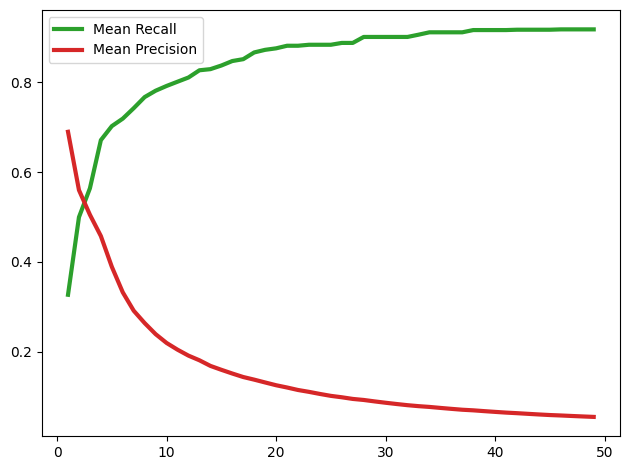

In [12]:
recall, precision = ensemble.evaluate(q_ids=q_ids, preds_doc_ids=preds, K=5, queries_obj=queries_obj, to_display="Voter Models")
ensemble.plot_eval_curve(q_ids=q_ids, queries_obj=queries_obj, preds_doc_ids=preds, max_k=50)

## Thank you